# Prepare Data

In [58]:
! pip install rdkit

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [60]:
df = pd.read_csv('csv/bioactivity_preprocessed_data.csv')
df.head(5)

,molecule_chembl_id,canonical_smiles,standard_value,compound_classification
0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,5160.00,intermediate
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,1.15,active
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,4.20,active
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,33.40,active
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,27.60,active


# Calculate Lipinski Descriptors

In [61]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [62]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):
    
    moldata = [Chem.MolFromSmiles(elem) for elem in smiles]
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [63]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,311.208,4.74000,0.0,2.0
1,299.414,3.45900,0.0,3.0
2,385.245,3.03050,0.0,3.0
3,313.224,4.68620,0.0,2.0
4,328.239,3.73270,0.0,3.0
...,...,...,...,...
3495,237.730,3.00180,1.0,2.0
3496,237.730,3.00180,1.0,2.0
3497,237.730,3.00180,1.0,2.0
3498,514.483,4.66972,0.0,7.0


In [64]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,compound_classification,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,5160.00,intermediate,311.208,4.74000,0.0,2.0
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,1.15,active,299.414,3.45900,0.0,3.0
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,4.20,active,385.245,3.03050,0.0,3.0
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,33.40,active,313.224,4.68620,0.0,2.0
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,27.60,active,328.239,3.73270,0.0,3.0
...,...,...,...,...,...,...,...,...
3495,CHEMBL4847426,Clc1ccc(OC2CC3CCC(C2)N3)cc1,43.00,active,237.730,3.00180,1.0,2.0
3496,CHEMBL4851558,Clc1cccc(OC2CC3CCC(C2)N3)c1,135.00,active,237.730,3.00180,1.0,2.0
3497,CHEMBL4873377,Clc1ccccc1OC1CC2CCC(C1)N2,881.00,active,237.730,3.00180,1.0,2.0
3498,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,13.00,active,514.483,4.66972,0.0,7.0


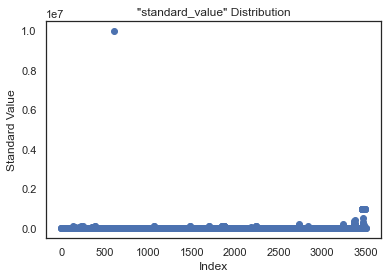

In [32]:
#IC50 data values have uneven distribution
x = []
y = []
i = 0
for j in df.standard_value:
    x.append(i)
    y.append(j)
    i += 1
    
plt.scatter(x, y)
plt.title('"standard_value" Distribution')
plt.xlabel('Index')
plt.ylabel('Standard Value')
plt.show()

In [33]:
#transform IC50 data values - negative logarithmic

# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value', axis=1)
        
    return x

In [34]:
#we dont want the transformed values to be negative as it will make data interpretation more difficult
#to prevent that from happening, we make sure the resulting values will not be < 1.0
#this means, the input values should not exceed 1000000
-np.log10((10**-9)* 100000000)

1.0

In [35]:
#check whether the max value will result in < 1.0
df_combined.standard_value.describe()

count    3.500000e+03
mean     1.368293e+04
std      1.883548e+05
min      0.000000e+00
25%      1.700000e+01
50%      1.582450e+02
75%      1.352500e+03
max      1.000000e+07
Name: standard_value, dtype: float64

In [36]:
df_final = pIC50(df_combined)
df_final

/var/folders/zp/55hhmnvj5ys7j9j8dtzqm6wh0000gn/T/ipykernel_20952/2371749218.py:12: RuntimeWarning: divide by zero encountered in log10
  pIC50.append(-np.log10(molar))


,molecule_chembl_id,canonical_smiles,compound_classification,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,intermediate,311.208,4.74000,0.0,2.0,5.287350
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,active,299.414,3.45900,0.0,3.0,8.939302
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,active,385.245,3.03050,0.0,3.0,8.376751
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,active,313.224,4.68620,0.0,2.0,7.476254
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,active,328.239,3.73270,0.0,3.0,7.559091
...,...,...,...,...,...,...,...,...
3495,CHEMBL4847426,Clc1ccc(OC2CC3CCC(C2)N3)cc1,active,237.730,3.00180,1.0,2.0,7.366532
3496,CHEMBL4851558,Clc1cccc(OC2CC3CCC(C2)N3)c1,active,237.730,3.00180,1.0,2.0,6.869666
3497,CHEMBL4873377,Clc1ccccc1OC1CC2CCC(C1)N2,active,237.730,3.00180,1.0,2.0,6.055024
3498,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,active,514.483,4.66972,0.0,7.0,7.886057


In [37]:
df_final.pIC50.describe()

count    3500.000000
mean             inf
std              NaN
min         2.000000
25%         5.868865
50%         6.800671
75%         7.769551
max              inf
Name: pIC50, dtype: float64

In [65]:
#remove infinity values
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_final.pIC50.describe()

count    3499.000000
mean        6.759904
std         1.243811
min         2.000000
25%         5.868064
50%         6.799998
75%         7.769551
max        11.698970
Name: pIC50, dtype: float64

In [80]:
#remove NaN values
df_final.dropna(inplace=True)
df_final.reset_index(drop=True, inplace=True)
df_final.shape

(3499, 8)

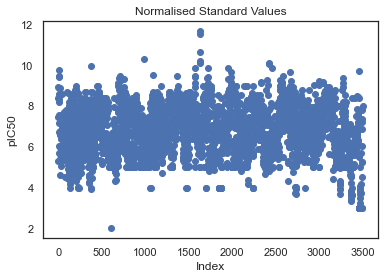

In [81]:
#check distribution
x = []
y = []
i = 0
for j in df_final.pIC50:
    x.append(i)
    y.append(j)
    i += 1
    
plt.scatter(x, y)
plt.title('Normalised Standard Values')
plt.xlabel('Index')
plt.ylabel('pIC50')
plt.show()

# prepare 2 bioactivity classes

In [82]:
#remove intermediate class
df_2class = df_final[df_final.compound_classification != 'intermediate']
df_2class.reset_index(drop=True, inplace=True)
df_2class

,molecule_chembl_id,canonical_smiles,compound_classification,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,active,299.414,3.45900,0.0,3.0,8.939302
1,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,active,385.245,3.03050,0.0,3.0,8.376751
2,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,active,313.224,4.68620,0.0,2.0,7.476254
3,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,active,328.239,3.73270,0.0,3.0,7.559091
4,CHEMBL316342,COC(=O)C1C2CCC(CC1c1ccc(Cl)c(Cl)c1)O2,active,315.196,3.81750,0.0,3.0,8.187087
...,...,...,...,...,...,...,...,...
2829,CHEMBL4847426,Clc1ccc(OC2CC3CCC(C2)N3)cc1,active,237.730,3.00180,1.0,2.0,7.366532
2830,CHEMBL4851558,Clc1cccc(OC2CC3CCC(C2)N3)c1,active,237.730,3.00180,1.0,2.0,6.869666
2831,CHEMBL4873377,Clc1ccccc1OC1CC2CCC(C1)N2,active,237.730,3.00180,1.0,2.0,6.055024
2832,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,active,514.483,4.66972,0.0,7.0,7.886057


In [83]:
#save df_combined to be used later
path = 'csv/'
df_2class.to_csv(os.path.join(path,'combined_dataset_pIC50.csv'),index=False)

# EDA via Lipinski Descriptors

In [84]:
import seaborn as sns
sns.set(style='white')

### Compare Bioactivity Class 

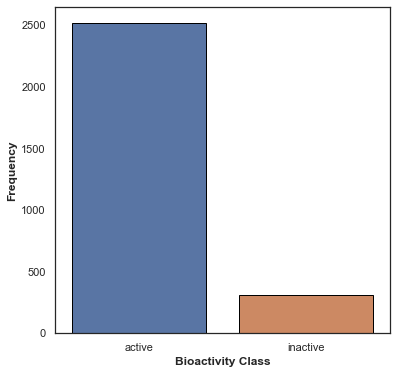

In [85]:
plt.figure(figsize=(6,6))

sns.countplot(x='compound_classification', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity Class', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')

plt.savefig('figures/bioactivity_class_fig.jpg')

### Compare Molecular Weight (MW) versus Solubility (LogP)

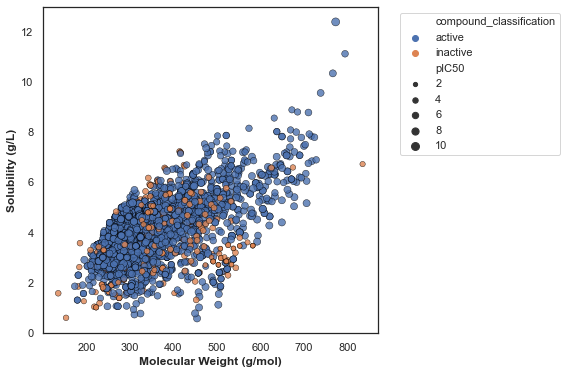

In [86]:
plt.figure(figsize=(6,6))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='compound_classification', size='pIC50', edgecolor='black', alpha=0.8)

plt.xlabel('Molecular Weight (g/mol)', fontweight='bold')
plt.ylabel('Solubility (g/L)', fontweight='bold')
plt.legend(bbox_to_anchor=(1.05,1))

plt.savefig('figures/MW_vs_LogP_fig.jpg')

### Box Plot for pIC50 Values 

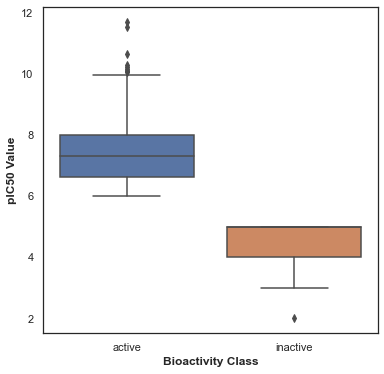

In [87]:
plt.figure(figsize=(6,6))

sns.boxplot(x='compound_classification', y='pIC50',data=df_2class)

plt.xlabel('Bioactivity Class', fontweight='bold')
plt.ylabel('pIC50 Value', fontweight='bold')

plt.savefig('figures/pIC50_fig.jpg')

### Statistical Analysis | Mann-Whitney U Test 

In [88]:
def mannwhitney(descriptor, verbose=False):
    # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

    # seed the random number generator
    seed(1)

    # actives and inactives
    selection = [descriptor, 'compound_classification']
    df = df_2class[selection]
    active = df[df.compound_classification == 'active']
    active = active[descriptor]

    selection = [descriptor, 'compound_classification']
    df = df_2class[selection]
    inactive = df[df.compound_classification == 'inactive']
    inactive = inactive[descriptor]

    # compare samples
    stat, p = mannwhitneyu(active, inactive)
    #print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'

    results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    return results

In [89]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,789073.0,1.206404e-183,0.05,Different distribution (reject H0)


### Molecular Weight

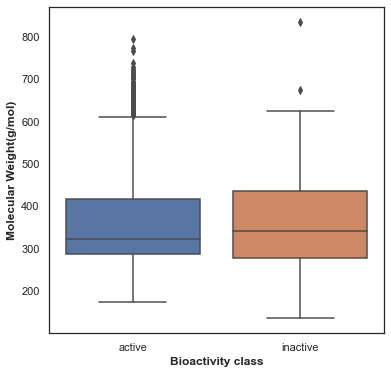

In [90]:
plt.figure(figsize=(6,6))

sns.boxplot(x = 'compound_classification', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontweight='bold')
plt.ylabel('Molecular Weight(g/mol)', fontweight='bold')

plt.savefig('figures/plot_MW.jpg')

In [91]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,384254.5,0.451431,0.05,Same distribution (fail to reject H0)


### Solubility

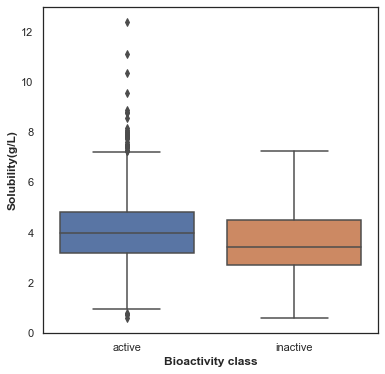

In [92]:
plt.figure(figsize=(6,6))

sns.boxplot(x = 'compound_classification', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontweight='bold')
plt.ylabel('Solubility(g/L)', fontweight='bold')

plt.savefig('figures/plot_LogP.jpg')

In [93]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,477303.5,1.344974e-09,0.05,Different distribution (reject H0)


### NumHDonors

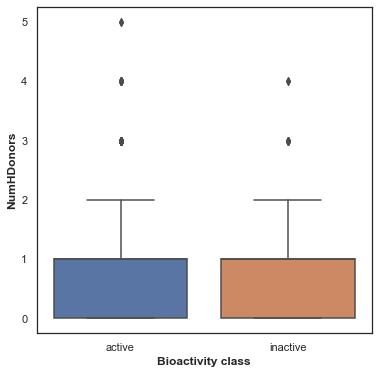

In [94]:
plt.figure(figsize=(6,6))

sns.boxplot(x = 'compound_classification', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontweight='bold')
plt.ylabel('NumHDonors', fontweight='bold')

plt.savefig('figures/plot_NumHDonors.jpg')

In [95]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,446229.5,0.000027,0.05,Different distribution (reject H0)


### NumHAcceptors

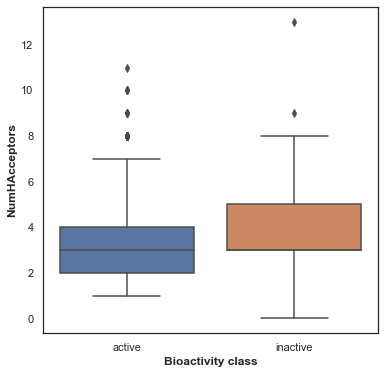

In [96]:
plt.figure(figsize=(6,6))

sns.boxplot(x = 'compound_classification', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontweight='bold')
plt.ylabel('NumHAcceptors', fontweight='bold')

plt.savefig('figures/plot_NumHAcceptors.jpg')

In [97]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,306980.5,4.144423e-11,0.05,Different distribution (reject H0)


# Interpretation